In [68]:
import sys
sys.path.append('..')
from models.scnn_pytorch.model import SCNN
from models.erfnet.erfnet import ERFNet
import torch
import os
import cv2
import numpy as np
import time
import torchvision
import matplotlib.pyplot as plt

In [69]:
drive_window_region = np.array([600.0 / 1920, 280.0 / 1080, 1000.0 / 1920, 360.0 / 1080])


def GetRectFromRegion(region: np.array, width, height):
    x = float(width) * region[0]
    y = float(height) * region[1]
    region_width = float(width) * region[2]
    region_height = float(height) * region[3]
    return np.array([x, y, region_width, region_height], dtype=np.int)

rect = GetRectFromRegion(drive_window_region, 1920, 1080)

In [68]:
MODEL_DIR = '../models/scnn_pytorch'
INPUT_SIZE = (800, 288)
net = SCNN(input_size=INPUT_SIZE, pretrained=False, test=True)
state = torch.load(MODEL_DIR + '/exp10_best.pth')
net.load_state_dict(state['net'])
net.eval().cuda().half()

mean = (0.3598, 0.3653, 0.3662)
std = (0.2573, 0.2663, 0.2756)

cv2.namedWindow('result')

for filename in os.listdir('../images'):
    img = cv2.imread('../images/' + filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    drive_window_img = img[rect[1]:rect[1] + rect[3], rect[0]:rect[0] + rect[2]]
    input_blob = drive_window_img.astype(np.float)
    input_blob = input_blob / 255.0
    input_blob = (input_blob - mean) / std
    input_blob = cv2.resize(input_blob, INPUT_SIZE)
    input_blob = input_blob.transpose([2, 0, 1])

    input_tensor = torch.from_numpy(np.array([input_blob]))
    input_tensor = input_tensor.float().cuda().half()

    seg, exist = net(input_tensor)
    seg_img = seg.cpu().numpy().astype(np.uint8)

    seg_img = cv2.cvtColor(seg_img, cv2.COLOR_GRAY2RGB)
    seg_img = cv2.resize(seg_img, (1280, 720), interpolation=cv2.INTER_LINEAR)
    drive_window_img = cv2.resize(drive_window_img, (1280, 720))
    blend = cv2.addWeighted(seg_img * 50, 0.5, drive_window_img, 0.8, 0)

    cv2.imshow('result', blend)
    if cv2.waitKey(500) == 27:
        break
cv2.destroyWindow('result')

RuntimeError: Input type (torch.cuda.HalfTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [72]:
erf_net = ERFNet(5)
input_mean = erf_net.input_mean
input_std = erf_net.input_std
erf_net = torch.nn.DataParallel(erf_net, device_ids=[0]).cuda()
checkpoint = torch.load('D:/Dev/Codes-for-Lane-Detection/ERFNet-CULane-PyTorch/trained/ERFNet_trained.tar')
erf_net.load_state_dict(checkpoint['state_dict'])
erf_net.eval()
pass

In [75]:
cv2.namedWindow('result')
cv2.moveWindow('result', 200,200)
for filename in os.listdir('../images'):
    img = cv2.imread('../images/' + filename)

    drive_window_img = img[rect[1]:rect[1] + rect[3], rect[0]:rect[0] + rect[2]]
    #drive_window_img = cv2.copyMakeBorder( drive_window_img, 0, 0, 400, 200, cv2.BORDER_CONSTANT)

    drive_window_img = drive_window_img.astype(np.float)
    input_blob = (drive_window_img - input_mean) / input_std
    input_blob = cv2.resize(input_blob, (976, 208))
    input_blob = input_blob.transpose([2, 0, 1])

    input_tensor = torch.from_numpy(np.array([input_blob]))
    input_tensor = input_tensor.float().cuda()

    seg, exist = erf_net(input_tensor)

    seg = seg.detach().cpu().numpy()
    seg_img = np.argmax(seg[0], axis=0).astype(np.uint8)
    

    seg_img = cv2.cvtColor(seg_img, cv2.COLOR_GRAY2RGB)
    seg_img = cv2.resize(seg_img, (1280, 720), interpolation=cv2.INTER_LINEAR)
    drive_window_img = cv2.resize(drive_window_img, (1280, 720))
    blend = cv2.addWeighted(seg_img * 50, 0.5, drive_window_img.astype(np.uint8), 0.8, 0)

    cv2.imshow('result', blend)
    if cv2.waitKey(500) == 27:
        break
cv2.destroyWindow('result')

In [4]:
# merge

erf_net = ERFNet(5)
input_mean = erf_net.input_mean
input_std = erf_net.input_std
erf_net = torch.nn.DataParallel(erf_net, device_ids=[0]).cuda()
checkpoint = torch.load('D:/Dev/Codes-for-Lane-Detection/ERFNet-CULane-PyTorch/trained/ERFNet_trained.tar')
erf_net.load_state_dict(checkpoint['state_dict'])
erf_net.eval()
pass

#scnn
MODEL_DIR = '../models/scnn_pytorch'
INPUT_SIZE = (800, 288)
scnn_net = SCNN(input_size=INPUT_SIZE, pretrained=False, test=True)
state = torch.load(MODEL_DIR + '/exp10_best.pth')
scnn_net.load_state_dict(state['net'])
scnn_net.eval().cuda().half()
mean = (0.3598, 0.3653, 0.3662)
std = (0.2573, 0.2663, 0.2756)

cv2.namedWindow('result')
cv2.moveWindow('result', 200,200)
for filename in os.listdir('../images'):
    img = cv2.imread('../images/' + filename)
    drive_window_img = img[rect[1]:rect[1] + rect[3], rect[0]:rect[0] + rect[2]]
    drive_window_img = drive_window_img.astype(np.float)
    
    #erf_net
    input_blob = (drive_window_img.copy() - input_mean) / input_std
    input_blob = cv2.resize(input_blob, (976, 208))
    input_blob = input_blob.transpose([2, 0, 1])

    input_tensor = torch.from_numpy(np.array([input_blob]))
    input_tensor = input_tensor.float().cuda()
    seg, exist = erf_net(input_tensor)
    seg = seg.detach().cpu().numpy()
    erf_seg_img = np.argmax(seg[0], axis=0).astype(np.uint8)
    erf_seg_img = cv2.resize(erf_seg_img, (1280, 720), interpolation=cv2.INTER_LINEAR)
    
    #scnn
    input_blob = drive_window_img.copy() / 255.0
    input_blob = (input_blob - mean) / std
    input_blob = cv2.resize(input_blob, INPUT_SIZE)
    input_blob = input_blob.transpose([2, 0, 1])

    input_tensor = torch.from_numpy(np.array([input_blob]))
    input_tensor = input_tensor.float().cuda().half()

    seg, exist = scnn_net(input_tensor)
    scnn_seg_img = seg.cpu().numpy().astype(np.uint8)
    scnn_seg_img = cv2.resize(scnn_seg_img, (1280, 720), interpolation=cv2.INTER_LINEAR)

    merge_seg_img = scnn_seg_img + erf_seg_img
    
    merge_seg_img = cv2.cvtColor(merge_seg_img, cv2.COLOR_GRAY2RGB)
    merge_seg_img = cv2.resize(merge_seg_img, (1280, 720), interpolation=cv2.INTER_LINEAR)
    drive_window_img = cv2.resize(drive_window_img, (1280, 720))
    blend = cv2.addWeighted(merge_seg_img * 30, 0.5, drive_window_img.astype(np.uint8), 0.8, 0)

    cv2.imshow('result', blend)
    if cv2.waitKey(500) == 27:
        break
cv2.destroyWindow('result')




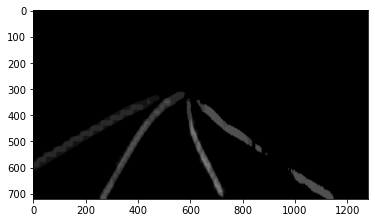

In [9]:
plt.imshow(merge_seg_img * 20)

In [6]:
input_mean

[103.939, 116.779, 123.68]

In [10]:
sys.path.append('../models/PINet')
from models.PINet import agent

In [11]:
net = agent.Agent()
state = torch.load('../models/PINet/savefile/640_tensor(0.2298)_lane_detection_network.pkl')
net.lane_detection_network.load_state_dict(state)

net.cuda()
net.evaluate_mode()


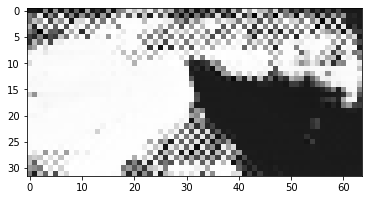

In [12]:
test_image = cv2.imread("../images/1591496760409.png")
test_image = cv2.resize(test_image, (512,256))/255.0
input_blob = test_image.transpose([2, 0, 1])
input_blob = np.array([input_blob])

confidences, offsets, instances = net.predict_lanes_test(input_blob)[-1]
confidences = (instances[0][0].detach().cpu().numpy())
plt.imshow(confidences, cmap='gray')
confidences = confidences.astype(np.uint8)
confidences = cv2.resize(confidences, (1280, 720), interpolation=cv2.INTER_LINEAR)
confidences = cv2.cvtColor(confidences, cv2.COLOR_GRAY2RGB)


In [21]:
cv2.namedWindow('result')
cv2.moveWindow('result', 200,200)
for filename in os.listdir('../images'):
    img = cv2.imread('../images/' + filename)

    drive_window_img = img[rect[1]:rect[1] + rect[3], rect[0]:rect[0] + rect[2]-200]
    input_blob = drive_window_img.astype(np.float)
    input_blob = cv2.resize(input_blob, (512,256)) / 255.0
    input_blob = input_blob.transpose([2, 0, 1])

    input_tensor = np.array([input_blob])

    confidences, offsets, instances = net.predict_lanes_test(input_tensor)[-1]
    confidences = (confidences[0][0].detach().cpu().numpy())
    confidences = confidences.astype(np.uint8)
    confidences = cv2.resize(confidences, (1280, 720), interpolation=cv2.INTER_LINEAR)
    confidences = cv2.cvtColor(confidences, cv2.COLOR_GRAY2RGB)
    drive_window_img = cv2.resize(drive_window_img, (1280, 720))
    blend = cv2.addWeighted(confidences * 50, 0.8, drive_window_img, 0.8, 0)

    cv2.imshow('result', blend)
    if cv2.waitKey(500) == 27:
        break
cv2.destroyWindow('result')

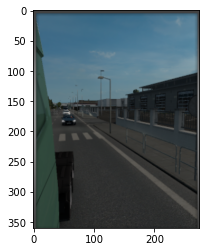

In [212]:
img = cv2.imread('../images/1591496721867.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

right_mirror_region = np.array([1620.0/1920, 90.0/1080, 275.0/1920, 360.0 / 1080 ])
rect = GetRectFromRegion(right_mirror_region, 1920, 1080)
right_mirror_img = img[rect[1]:rect[1] + rect[3], rect[0]:rect[0]+rect[2]]
plt.imshow(right_mirror_img)

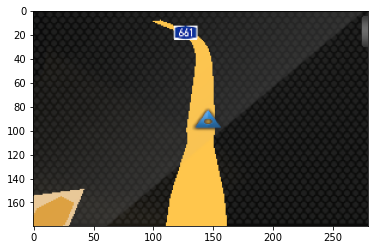

In [242]:
img = cv2.imread('../images/1591496756125.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

right_mirror_region = np.array([1540.0/1920, 770.0/1080, 280.0/1920, 180.0 / 1080 ])
rect = GetRectFromRegion(right_mirror_region, 1920, 1080)
map_img = img[rect[1]:rect[1] + rect[3], rect[0]:rect[0]+rect[2]]
plt.imshow(map_img)

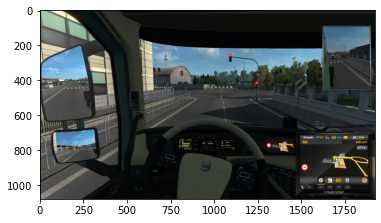

In [213]:
plt.imshow(img)

In [148]:
import onnxruntime

In [152]:
session = onnxruntime.InferenceSession('../models/yolo3/yolov3.onnx')

In [243]:
image_input_name = session.get_inputs()[0].name
shape_input_name = session.get_inputs()[1].name
output_names = []
output_names.append(session.get_outputs()[0].name)
output_names.append(session.get_outputs()[1].name)
output_names.append(session.get_outputs()[2].name)
for name in output_names:
    print(name)

yolonms_layer_1/ExpandDims_1:0
yolonms_layer_1/ExpandDims_3:0
yolonms_layer_1/concat_2:0


In [214]:
import numpy as np
from PIL import Image

# this function is from yolo3.utils.letterbox_image
def letterbox_image(image, size):
    '''resize image with unchanged aspect ratio using padding'''
    iw, ih = image.size
    w, h = size
    scale = min(w/iw, h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)

    image = image.resize((nw,nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128,128,128))
    new_image.paste(image, ((w-nw)//2, (h-nh)//2))
    return new_image

def preprocess(img):
    model_image_size = (416, 416)
    boxed_image = letterbox_image(img, tuple(reversed(model_image_size)))
    image_data = np.array(boxed_image, dtype='float32')
    image_data /= 255.
    image_data = np.transpose(image_data, [2, 0, 1])
    image_data = np.expand_dims(image_data, 0)
    return image_data

right_mirror_img = cv2.resize(right_mirror_img, (416,416))
image = Image.fromarray(right_mirror_img)
# input
image_data = preprocess(image)
image_size = np.array([image.size[1], image.size[0]], dtype=np.float32).reshape(1, 2)
print(image_data.dtype)

float32


In [215]:
print(image_data.dtype)
print(image_size.dtype)

float32
float32


In [255]:
outputs = session.run(output_names, {image_input_name: image_data, shape_input_name: image_size})

In [258]:
out_boxes, out_scores, out_classes = [], [], []

In [264]:
indices = outputs[0].shape[1]

In [ ]:
for idx_ in indices:
    out_classes.append(idx_[1])
    out_scores.append(scores[tuple(idx_)])
    idx_1 = (idx_[0], idx_[2])
    out_boxes.append(boxes[idx_1])

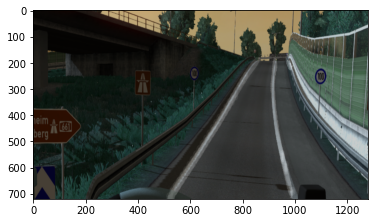

In [5]:
# merge

erf_net = ERFNet(5)
input_mean = erf_net.input_mean
input_std = erf_net.input_std
erf_net = torch.nn.DataParallel(erf_net, device_ids=[0]).cuda()
checkpoint = torch.load('D:/Dev/Codes-for-Lane-Detection/ERFNet-CULane-PyTorch/trained/ERFNet_trained.tar')
erf_net.load_state_dict(checkpoint['state_dict'])
erf_net.eval()
pass

#scnn
MODEL_DIR = '../models/scnn_pytorch'
INPUT_SIZE = (800, 288)
scnn_net = SCNN(input_size=INPUT_SIZE, pretrained=False, test=True)
state = torch.load(MODEL_DIR + '/exp10_best.pth')
scnn_net.load_state_dict(state['net'])
scnn_net.eval().cuda().half()
mean = (0.3598, 0.3653, 0.3662)
std = (0.2573, 0.2663, 0.2756)

cv2.namedWindow('result')
cv2.moveWindow('result', 200,200)


C:\Users\DHH\miniconda3\envs\ets2\lib\site-packages\torch\nn\functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.30597567558288574


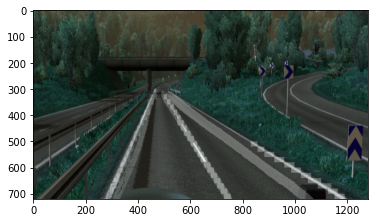

In [169]:
start = time.time()
lanes = []

img = cv2.imread('../images/1591496785208.png')
drive_window_img = img[rect[1]:rect[1] + rect[3], rect[0]:rect[0] + rect[2]]
drive_window_img = drive_window_img.astype(np.float)

#erf_net
input_blob = (drive_window_img.copy() - input_mean) / input_std
input_blob = cv2.resize(input_blob, (976, 208))
input_blob = input_blob.transpose([2, 0, 1])

input_tensor = torch.from_numpy(np.array([input_blob]))
input_tensor = input_tensor.float().cuda()
seg, exist = erf_net(input_tensor)
seg = seg.detach().cpu().numpy()
erf_seg_img = np.argmax(seg[0], axis=0).astype(np.uint8)
erf_seg_img = cv2.resize(erf_seg_img, (1280, 720), interpolation=cv2.INTER_NEAREST)
for i in range(5):
    lanes.append(cv2.inRange(erf_seg_img, i, i))


#scnn
input_blob = drive_window_img.copy() / 255.0
input_blob = (input_blob - mean) / std
input_blob = cv2.resize(input_blob, INPUT_SIZE)
input_blob = input_blob.transpose([2, 0, 1])

input_tensor = torch.from_numpy(np.array([input_blob]))
input_tensor = input_tensor.float().cuda().half()

seg, exist = scnn_net(input_tensor)
scnn_seg_img = seg.cpu().numpy().astype(np.uint8)
scnn_seg_img = cv2.resize(scnn_seg_img, (1280, 720), interpolation=cv2.INTER_NEAREST)
for i in range(5):
    lanes[i] = lanes[i] + (cv2.inRange(scnn_seg_img, i, i))


merge_seg_img = scnn_seg_img + erf_seg_img

merge_seg_img = cv2.cvtColor(merge_seg_img, cv2.COLOR_GRAY2RGB)
merge_seg_img = cv2.resize(merge_seg_img, (1280, 720), interpolation=cv2.INTER_LINEAR)
drive_window_img = cv2.resize(drive_window_img, (1280, 720))
blend = cv2.addWeighted(merge_seg_img * 30, 0.5, drive_window_img.astype(np.uint8), 0.8, 0)

print(time.time() - start)
plt.imshow(blend)


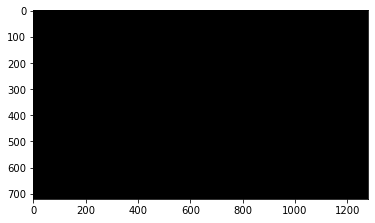

In [78]:
plt.imshow(lanes[1], cmap='gray')

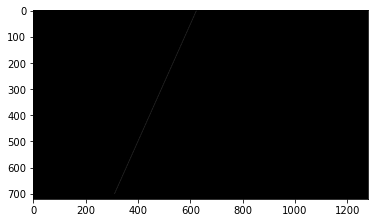

In [153]:
plt.imshow(lanes[2], cmap='gray')
y, x  = np.where(lanes[2] == 255)
f = np.poly1d(np.polyfit(x, y, 1))
x_new = np.linspace(0, 1200, 50).astype(np.int)
y_new = f(x_new).astype(np.int)
fit_img = np.zeros_like(lanes[2])
for x in range(0,1200):
    y = np.int(f(x))
    if y > 700 or y < 0:
        continue
    fit_img[y][x] = 255
plt.imshow(fit_img, cmap='gray')

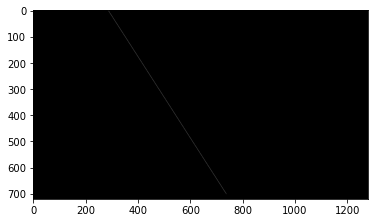

In [167]:
plt.imshow(lanes[3], cmap='gray')
y, x  = np.where(lanes[3] == 255)
f = np.poly1d(np.polyfit(x, y, 1))
x_new = np.linspace(0, 1200, 50).astype(np.int)
y_new = f(x_new).astype(np.int)
fit_img = np.zeros_like(lanes[2])
for x in range(0,1200):
    y = np.int(f(x))
    if y > 700 or y < 0:
        continue
    fit_img[y][x] = 255
plt.imshow(fit_img, cmap='gray')

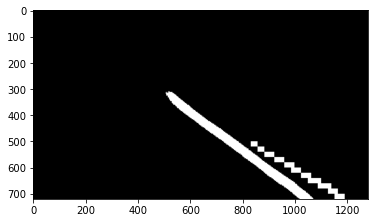

In [168]:
plt.imshow(lanes[4], cmap='gray')
y, x  = np.where(lanes[4] == 255)
f = np.poly1d(np.polyfit(x, y, 1))
x_new = np.linspace(0, 1200, 50).astype(np.int)
y_new = f(x_new).astype(np.int)
fit_img = np.zeros_like(lanes[2])
for x in range(0,1200):
    y = np.int(f(x))
    if y > 700 or y < 0:
        continue
    fit_img[y][x] = 255
# plt.imshow(fit_img, cmap='gray')

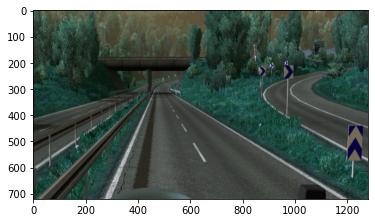

In [205]:
plt.imshow(drive_window_img.astype(np.int))

In [77]:
lanes[2]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [194]:
fit_img = []
for i in range(1, 5):
    fit_img.append(np.zeros_like(lanes[i]))
    y, x  = np.where(lanes[i] == 255)
    if len(x) == 0:
        continue
    f = np.poly1d(np.polyfit(x, y, 1))
    x_new = np.linspace(0, 1200, 50).astype(np.int)
    y_new = f(x_new).astype(np.int)
    
    for x in range(0,1200):
        y = np.int(f(x))
        if y > 700 or y < 0:
            continue
        fit_img[i - 1][y][x] = 255

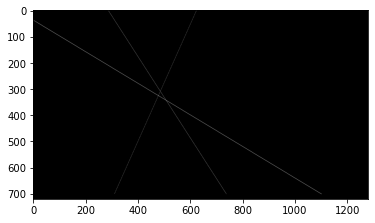

In [202]:
plt.imshow(fit_img[0]+fit_img[1]+fit_img[2]+fit_img[3], cmap='gray')